[*********************100%***********************]  1 of 1 completed


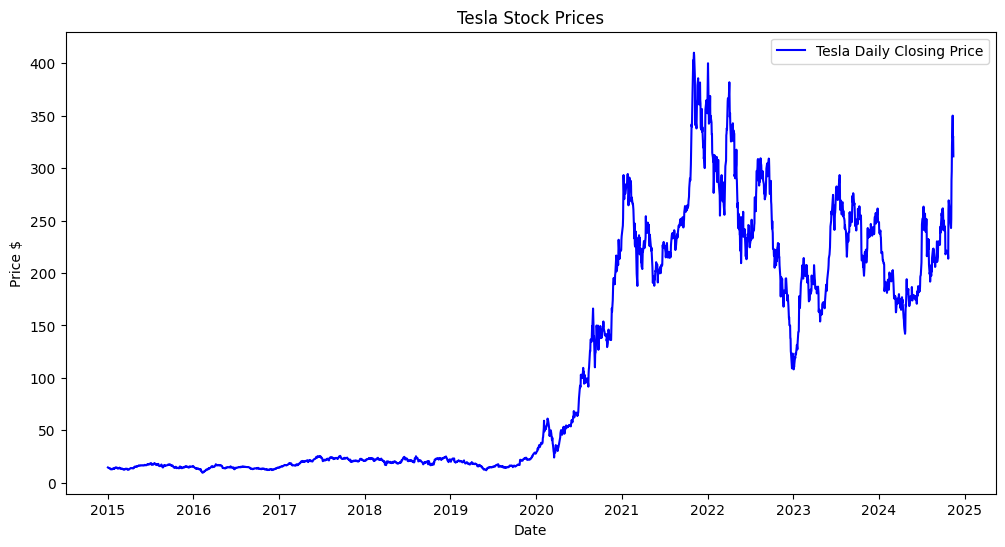

In [511]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Load Tesla stock data (using closing price)
data = yf.download("TSLA", start="2015-01-01", end="2024-11-15")
close_data = data[['Close']]

# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(close_data['Close'], label='Tesla Daily Closing Price', color='blue')
plt.title('Tesla Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price $')
plt.legend()
plt.show()


In [512]:
# Feature Engineering directly from the 'Close' column
engineered_data = close_data[['Close']]

# Lagged Values
engineered_data['Lag_1'] = engineered_data['Close'].shift(1)  # Previous day's closing price

# Moving Averages
engineered_data['MA_7'] = engineered_data['Close'].rolling(window=7).mean()  # 7-day moving average

# Volatility
engineered_data['Volatility_7'] = engineered_data['Close'].rolling(window=7).std()  # Standard deviation over 7 days

# Drop rows with NaN values
final_data = engineered_data.dropna().reset_index(drop=True)

# Preview the engineered features
print(final_data.head())


Price       Close      Lag_1       MA_7 Volatility_7
Ticker       TSLA                                   
0       13.480667  13.777333  14.010667     0.345629
1       13.616667  13.480667  13.867238     0.243546
2       12.846000  13.616667  13.701524     0.444847
3       12.791333  12.846000  13.516667     0.521099
4       12.871333  12.791333  13.346381     0.507263


In [513]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler instance to normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the entire DataFrame (final_data)
normalized_data = scaler.fit_transform(final_data)

# Step 4: Split Data into Training and Testing Sets
train_size = int(len(normalized_data) * 0.8)  # 80% for training and validation
train_data = normalized_data[:train_size]  # First 80% as training data
test_data = normalized_data[train_size:]  # Remaining 20% as test data

# Further split the training data into training and validation sets
train_valid_size = int(len(train_data) * 0.8)  # 80% of train_data for training
train_data_final = train_data[:train_valid_size]  # First 80% of training data for actual training
valid_data = train_data[train_valid_size:]  # Remaining 20% of training data for validation

# Print the sizes for verifi
print(f"Train data size: {len(train_data_final)}")
print(f"Validation data size: {len(valid_data)}")
print(f"Test data size: {len(test_data)}")


Train data size: 1586
Validation data size: 397
Test data size: 496


In [515]:
import torch
import numpy as np

# Function to create sequences for multivariate data
def create_sequences_multivariate(data, n_timesteps, target_column_index):
    X, y = [], []
    for i in range(len(data) - n_timesteps):
        seq_x = data[i:i + n_timesteps, :]  # All features
        seq_y = data[i + n_timesteps, target_column_index]  # Target column
        X.append(seq_x)
        y.append(seq_y)
    # Convert lists to numpy arrays first
    X = np.array(X)
    y = np.array(y)
    # Convert to torch tensors
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Number of timesteps
n_timesteps = 60  #  can adjust this

# Target column index for the 'Close' column
target_column_index = 0

# Create sequences for training, validation, and testing using DataFrames
X_train_tensor, y_train_tensor = create_sequences_multivariate(train_data_final, n_timesteps, target_column_index)
X_valid_tensor, y_valid_tensor = create_sequences_multivariate(valid_data, n_timesteps, target_column_index)
X_test_tensor, y_test_tensor = create_sequences_multivariate(test_data, n_timesteps, target_column_index)


In [516]:
from torch.utils.data import DataLoader, TensorDataset

# Create TensorDatasets for training, validation, and test sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
batch_size = 32  # can adjust this
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [517]:
import torch.nn as nn

# Define the RNN Model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)  # RNN forward pass
        out = self.fc(out[:, -1, :])  # Use the output from the last time step
        return out

# Hyperparameters
input_size = X_train_tensor.shape[2]  # Number of features
hidden_size = 70  # can adjust
num_layers = 2  # Minimum of 2 hidden layers as required
output_size = 1  # Predicting a single value (Tesla closing price)

# Instantiate the model
model = RNNModel(input_size, hidden_size, num_layers, output_size)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [519]:
# Training Loop
num_epochs = 20 # Adjust based on performance
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        outputs = outputs.squeeze(-1)  # Match target shape
        loss = criterion(outputs, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    # Validation phase
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in valid_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            val_outputs = model(X_val_batch)
            val_outputs = val_outputs.squeeze(-1)  # Match target shape
            val_loss = criterion(val_outputs, y_val_batch)

            valid_loss += val_loss.item()

    valid_losses.append(valid_loss / len(valid_loader))

    # Print epoch stats
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}")


Epoch [1/20], Train Loss: 0.0001, Valid Loss: 0.0009
Epoch [2/20], Train Loss: 0.0001, Valid Loss: 0.0010
Epoch [3/20], Train Loss: 0.0001, Valid Loss: 0.0009
Epoch [4/20], Train Loss: 0.0001, Valid Loss: 0.0010
Epoch [5/20], Train Loss: 0.0001, Valid Loss: 0.0013
Epoch [6/20], Train Loss: 0.0001, Valid Loss: 0.0013
Epoch [7/20], Train Loss: 0.0001, Valid Loss: 0.0009
Epoch [8/20], Train Loss: 0.0001, Valid Loss: 0.0011
Epoch [9/20], Train Loss: 0.0001, Valid Loss: 0.0021
Epoch [10/20], Train Loss: 0.0001, Valid Loss: 0.0008
Epoch [11/20], Train Loss: 0.0001, Valid Loss: 0.0010
Epoch [12/20], Train Loss: 0.0001, Valid Loss: 0.0009
Epoch [13/20], Train Loss: 0.0001, Valid Loss: 0.0009
Epoch [14/20], Train Loss: 0.0001, Valid Loss: 0.0008
Epoch [15/20], Train Loss: 0.0001, Valid Loss: 0.0009
Epoch [16/20], Train Loss: 0.0001, Valid Loss: 0.0009
Epoch [17/20], Train Loss: 0.0001, Valid Loss: 0.0008
Epoch [18/20], Train Loss: 0.0001, Valid Loss: 0.0008
Epoch [19/20], Train Loss: 0.0001, Va

Mean Squared Error (MSE): 67.3558
Mean Absolute Error (MAE): 5.9101


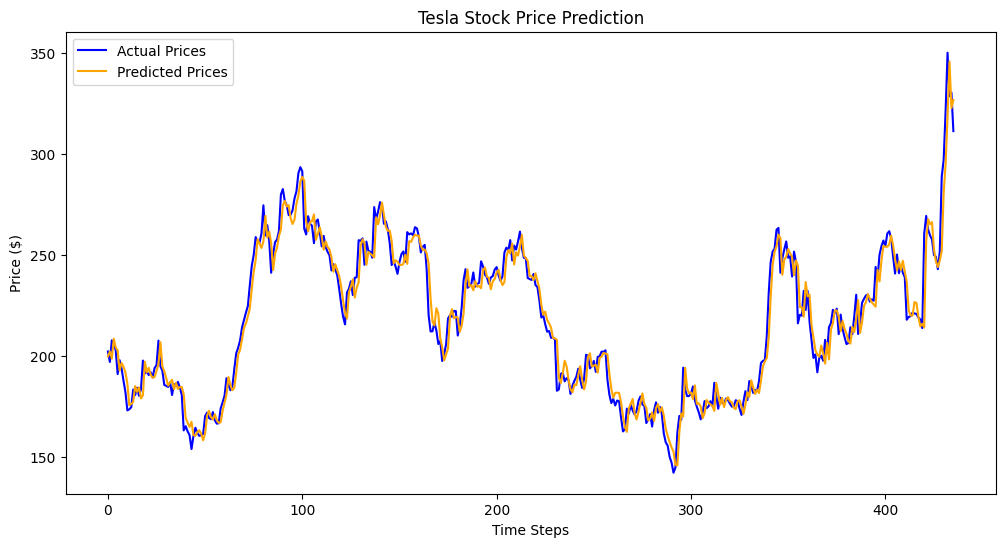

In [520]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluate on test data
model.eval()
with torch.no_grad():
    # Predict on test data
    test_predictions = model(X_test_tensor.to(device)).cpu().numpy()
    test_actuals = y_test_tensor.cpu().numpy()

# Denormalize the predictions and actual values
# Expand dimensions to match the scaler's input shape (e.g., add 7 zeros for other features
test_predictions_expanded = np.hstack([test_predictions.reshape(-1, 1)] + [np.zeros_like(test_predictions.reshape(-1, 1))] * 3)
test_actuals_expanded = np.hstack([test_actuals.reshape(-1, 1)] + [np.zeros_like(test_actuals.reshape(-1, 1))] * 3)

# Inverse transform and extract the first column (original 'Close' values)
predictions_denorm = scaler.inverse_transform(test_predictions_expanded)[:, 0]
actuals_denorm = scaler.inverse_transform(test_actuals_expanded)[:, 0]

# Calculate evaluation metrics
mse = mean_squared_error(actuals_denorm, predictions_denorm)
mae = mean_absolute_error(actuals_denorm, predictions_denorm)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(actuals_denorm, label='Actual Prices', color='blue')
plt.plot(predictions_denorm, label='Predicted Prices', color='orange')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

